
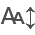

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from itables import show
from itables import init_notebook_mode
import json

# Set the maximum number of rows and columns displayed
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

# Set options for itables
init_notebook_mode(all_interactive=True)

%matplotlib inline

To view interactive components from github, click this link:
https://nbviewer.org/github/deannachurch/SBCapstone_CRISPRScreens/blob/main/notebooks/Brunello_count_library.ipynb

# Overview

**Purpose:** Understanding the distributions of crispr guide libraries to determine if we can make a simple app to do power calculations for experimental design. 

**Background:** There are a lot of variabilities in this screens, and lots of false positive. Understanding better ways we can understand effect sizes and the number of samples needed for a statistically significant experiment is useful, even if people can't do the recommended number of samples (for cost or experimental reasons)


# Functions

In [2]:
def define_outliers(df, col):
    """ 
    define_outliers

    Takes a dataframe and a column and calculates the IQR to remove outliers.
    Note- column must be numerical

    Calcualte the Q1, Q3 and IQR and return the outliers for later filtering
    """
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"The column {col} is not numeric")
    
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR = Q3-Q1

    outliers=(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    return(outliers)

In [3]:
def box_strip_plot(df, col, title, y_label):
    """ 
    Take a dataframe, the column of interest and some labeling info and make 
    box and stripplots

    return the fig
    """
    outliers=define_outliers(df, col)
    df_outliers = df[outliers]
    df_main = df[~outliers]

    out_melted_df = pd.melt(df_outliers, value_vars=col)
    main_melted_df = pd.melt(df_main, value_vars=col)
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)) 

    # Plot for main data without outliers on the first subplot
    sns.boxplot(x='variable', y='value', data=main_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[0])
    sns.stripplot(x='variable', y='value', data=main_melted_df, jitter=True, color='#CD8C0F', alpha=0.5, ax=axes[0])
    axes[0].set_title(f"{col}: Main Data without Outliers")
    axes[0].set_xlabel('')  # Turn off x-axis label
    axes[0].set_ylabel(y_label)  # Set y-axis label only for the left plot

    # Plot for outliers on the second subplot
    sns.boxplot(x='variable', y='value', data=out_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[1])
    sns.stripplot(x='variable', y='value', data=out_melted_df, color='#CD8C0F', jitter=True, ax=axes[1])
    axes[1].set_title(f"{col}: Outliers")
    axes[1].set_xlabel('')  # Turn off x-axis label
    axes[1].set_ylabel('')  # Turn off y-axis label for the right plot

    # Sort df_outliers to find the two biggest values
    top_outliers = df_outliers.sort_values(by=col, ascending=False).head(3)

    #Loop through the top outliers to add labels with 'Target Gene Symbol'
    for index, row in top_outliers.iterrows():
        axes[1].text(x=0+0.1, y=row[col], s=row['Target Gene Symbol'], color='black', va='center')

    # Annotation for the total number of data points in the main data plot
    total_main = len(df_main)
    axes[0].text(0.95, 0.95, f'Total: {total_main}', transform=axes[0].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    # Annotation for the total number of data points in the outliers plot
    total_outliers = len(df_outliers)
    axes[1].text(0.95, 0.95, f'Total: {total_outliers}', transform=axes[1].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    fig.suptitle(f"{col}: {title}")

    return fig

In [4]:
def plot_hist(df, col, bin_no, title, x_label):
    """ 
    Take a dataframe and column of interest, the bin number and plot label info
    and make a histogram of data.

    return the fig.
    """
    # Filter out null values
    non_null_df = guide_df[col].dropna()

    # Plot  histogram
    fig=plt.hist(non_null_df, bins=bin_no, edgecolor='black')

    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.title(title)

    return fig

# Read files

In [5]:
## files to analyze
#from original paper describing this library
#cells used A375 (a melanoma cell line)
brunello='../data/raw/Brunnello_libraryPaper/brunello_plasmid_counts.xlsx' #sheet 1 orig trac, sheet2 mod trac, sheet3 annotations
b_guide_annotation='../data/raw/Brunnello_libraryPaper/broadgpp-brunello-library-contents.txt' #guide annotation from current distributor

#from israeli et al paper, also used Brunello library but in CALU-3 cells
israeli='../data/raw/Israeli_2023/GSE197962_sgRNA_counts.txt'
i_b_guide_annotation='../data/raw/Israeli_2023/broadgpp-brunello-library-contents.txt' #info with this paper

# Check 1: guide list and annotation

Check the two guide files to ensure they contain the same data and annotations

In [6]:
b_guide_df=pd.read_csv(b_guide_annotation, delimiter='\t')
b_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [7]:
i_guide_df=pd.read_csv(i_b_guide_annotation, delimiter='\t')
i_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [8]:
## Check the shapes
print(f"The shape of the original file {b_guide_df.shape}")
print(f"The shape of the Israeli guide file {i_guide_df.shape}")

The shape of the original file (77441, 11)
The shape of the Israeli guide file (77441, 11)


In [9]:
diff = b_guide_df.compare(i_guide_df)
print(diff)

Empty DataFrame
Columns: []
Index: []


## conclusion: Guide source

The two guide definitaion data frames seem to be the same. Rename one to 'guide_df' and delete the other dataframe to save space

In [10]:
guide_df=b_guide_df
del i_guide_df
del b_guide_df
show(guide_df.head())

# Info on guide

- [X] How many non-targeting (control) guides
- [X] Distribution of guides per gene
- [X] How many guides are sense/antisense?
- [X] How many different and types of PAMs are targeted?
- [X] How many genes are targeted?
    - [X] Do we need to get transcript length? Will only get this for the one transcript in the file (not many of these have been updated.)
    - [X] Get isoform number [will just use the latest annotation based on gene for this]
    - [X] Add Essential/Non-Essential Annotation
    - [ ] Do we need to get gene length (that is exon + intron length) (holding off for now)
    - [ ] Expression? (may hold off for now as this could get quite complicated)

In [11]:
guide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target Gene ID                        76441 non-null  float64
 1   Target Gene Symbol                    77441 non-null  object 
 2   Target Transcript                     76441 non-null  object 
 3   Genomic Sequence                      76441 non-null  object 
 4   Position of Base After Cut (1-based)  76441 non-null  float64
 5   Strand                                76441 non-null  object 
 6   sgRNA Target Sequence                 77441 non-null  object 
 7   Target Context Sequence               76441 non-null  object 
 8   PAM Sequence                          76441 non-null  object 
 9   Exon Number                           76441 non-null  float64
 10  Rule Set 2 score                      76441 non-null  float64
dtypes: float64(4), 

In [12]:
# Export transcript list for looking up length in next notebook
tot_tx_list=guide_df['Target Transcript'].to_list()
tx_list=list(set(tot_tx_list))
with open('../data/processed/tx_list.txt', 'w') as file:
    for item in tx_list:
        file.write("%s\n" % item)


In [13]:
print(f"There are {guide_df['Target Gene Symbol'].nunique() -1} genes targeted (subtracted 1 for the 'Non-Targeting Control')")

There are 19114 genes targeted (subtracted 1 for the 'Non-Targeting Control')


In [14]:
gene_counts = guide_df['Target Gene Symbol'].value_counts()
print(gene_counts)

Target Gene Symbol
Non-Targeting Control    1000
WDR26                       4
RUFY1                       4
ORAI2                       4
PAAF1                       4
                         ... 
CT45A1                      2
MTRNR2L1                    2
CT45A2                      2
ZNF502                      2
DEFB107B                    1
Name: count, Length: 19115, dtype: int64


In [15]:
print(f"There are {gene_counts['Non-Targeting Control']} control guides")

There are 1000 control guides


In [16]:
# Filter out 'Non-Targeting Control' from gene_counts
# Calculate the frequency of guide counts
filtered_gene_counts = gene_counts[gene_counts.index != 'Non-Targeting Control']
guide_count_frequency = filtered_gene_counts.value_counts().sort_index()
freq=guide_count_frequency.reset_index(name='Gene Count')
freq.rename(columns={'count': 'Guide Count'}, inplace=True)


In [17]:
show(filtered_gene_counts.head())

In [18]:
gene_id_list=guide_df['Target Gene ID'].fillna(-1).astype(int).to_list()
gid_list=list(set(gene_id_list))
print(len(gid_list))
print(len(set(gid_list)))

19115
19115


In [19]:
print(gid_list)

[1, 2, 100129239, 131076, 9, 10, 12, 13, 14, 15, 16, 729447, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 163882, 43, 131118, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 70, 71, 72, 131149, 81, 100507003, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 163933, 97, 98, 100, 101, 102, 103, 104, 105, 131177, 107, 108, 109, 338692, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 196740, 196743, 140, 141, 142, 143, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 644809, 100129271, 173, 174, 175, 176, 177, 178, 220134, 181, 182, 183, 196792, 185, 186, 187, 189, 190, 191, 644815, 196, 197, 199, 202, 203, 204, 205, 164045, 207, 208, 100507027, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 149840, 229, 230, 231, 238, 239, 240, 241, 242, 246, 247, 248, 249, 250, 251, 164091, 257, 258, 

In [20]:
with open('../data/processed/gid_list.txt', 'w') as file:
    for item in gid_list:
        file.write("%s\n" % item)

In [21]:
# Summary statistics
summary_stats = filtered_gene_counts.describe()
print("Summary Statistics:\n", summary_stats)

# Detailed statistics
mean_value = filtered_gene_counts.mean()
median_value = filtered_gene_counts.median()
max_value = filtered_gene_counts.max()
min_value = filtered_gene_counts.min()

print("\nDetailed Statistics:")
print("Mean:", mean_value)
print("Median:", median_value)
print("Max:", max_value)
print("Min:", min_value)

Summary Statistics:
 count    19114.000000
mean         3.999215
std          0.041545
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: count, dtype: float64

Detailed Statistics:
Mean: 3.9992152349063512
Median: 4.0
Max: 4
Min: 1


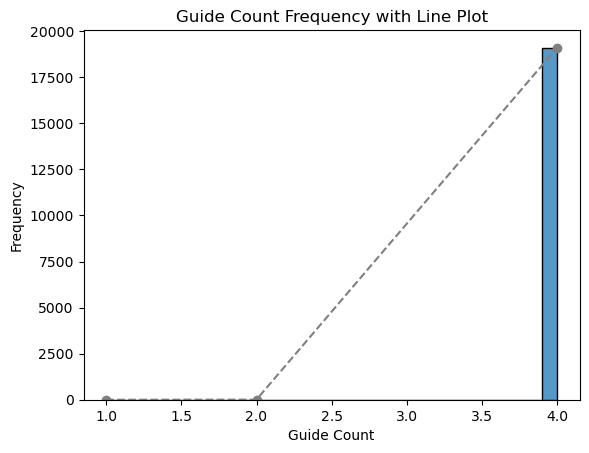

In [22]:
# Plotting the histogram
#Not using function as this one is a bit different
sns.histplot(data=freq, x='Guide Count', weights='Gene Count', bins=30, kde=False)

# Overlaying a line plot
plt.plot(freq['Guide Count'], freq['Gene Count'], marker='o', linestyle='--', color='grey')

# Adding labels and title
plt.xlabel('Guide Count')
plt.ylabel('Frequency')
plt.title('Guide Count Frequency with Line Plot')

# Show plot
plt.show()

# Conclusion: Guide distribution

All but two genes have 4 guides- there is very little count variation in this dataset. 

In [23]:
strand_counts = guide_df['Strand'].value_counts()

In [24]:
show(strand_counts)

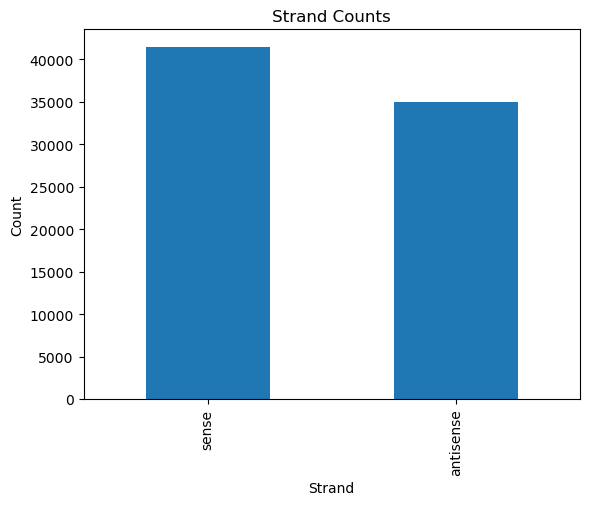

In [25]:
strand_counts.plot(kind='bar')
plt.xlabel('Strand')
plt.ylabel('Count')
plt.title('Strand Counts')
plt.show()

# Conclusion: Strand distribution

Fairly even split of sense/antisense strand, with slightly more sense strand guides

In [26]:
pam_counts = guide_df['PAM Sequence'].value_counts()
show(pam_counts)

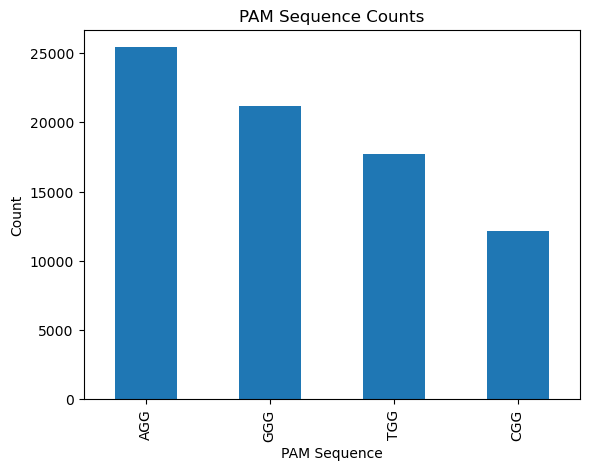

In [27]:
pam_counts.plot(kind='bar')
plt.xlabel('PAM Sequence')
plt.ylabel('Count')
plt.title('PAM Sequence Counts')
plt.show()

# Conclusion: PAM usage

Uneven distribution of PAM site usage.

# Add in gene length information

In [28]:
with open('../data/processed/tx_info.json', 'r') as file:
    tx_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(tx_dict.items())

# Create a DataFrame from the list of tuples
tx_df = pd.DataFrame(data, columns=['Target Transcript', 'Tx Length'])

# Show the first few rows of the DataFrame
show(tx_df.head())

# Merge length into into the main dataframe

In [29]:
#merge length info into the main dataframe
guide_len_df = guide_df.merge(tx_df, on='Target Transcript', how='left')

print(f"Null values in Tx Length column {guide_len_df['Tx Length'].isnull().sum()}")
#clean old dfs
#del guide_df
#del tx_df
#guide_df=guide_len_df


#show(guide_len_df.head())

Null values in Tx Length column 1000


# Question

The Tx length for non-targeting guides is NaN- which makes sense because they don't target anything. Should I leave as NaN or convert to a dummy number like -1?

OK- 1000 null values makes sense as there are 1000 non-targeting guides!

In [30]:
#clean old dfs
del guide_df
del tx_df
guide_df=guide_len_df

show(guide_df.head())
del guide_len_df

# Add in isoform number

In [31]:
with open('../data/processed/gene_isoform.json', 'r') as file:
    gene2iso_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(gene2iso_dict.items())

# Create a DataFrame from the list of tuples
gene2iso_df = pd.DataFrame(data, columns=['Target Gene ID', 'Gene Isoform Count'])

# Show the first few rows of the DataFrame
show(gene2iso_df.head())

In [32]:
gene2iso_df.dtypes

Target Gene ID        object
Gene Isoform Count     int64
dtype: object

In [33]:
gene2iso_df['Target Gene ID']=gene2iso_df['Target Gene ID'].astype(float)

In [34]:
#merge isoform count info into the main dataframe
guide_iso_df = guide_df.merge(gene2iso_df, on='Target Gene ID', how='left')

print(f"Null values in Gene Isoform column {guide_iso_df['Gene Isoform Count'].isnull().sum()}")

Null values in Gene Isoform column 1142


In [35]:
null_iso=guide_iso_df[guide_iso_df['Gene Isoform Count'].isnull()]
show(null_iso)

In [36]:
null_iso_gene=null_iso['Target Gene ID'].to_list()
null_iso_uniq=list(set(null_iso_gene))
print(f"missing isoform counts for {len(null_iso_uniq)}")

missing isoform counts for 1036


# Genes with missing isoform counts

There are 1036 of these, a manual review of a few of these suggests these have been withdraw from annotation since the guide library was made. In some cases these were converted to other genes, in others just dropped. Probably OK for now. 

In [37]:
#clean old dfs
del guide_df
del gene2iso_df
guide_df=guide_iso_df

show(guide_df.head())
del guide_iso_df

# Annotate gene essentiality

In [38]:
gene_annot=pd.read_csv('../data/processed/gene_annot.csv')
display(gene_annot)

Target Gene ID    Annotation
0            10189.0     Essential
1             9716.0     Essential
2              372.0     Essential
3            55299.0     Essential
4                NaN     Essential
...              ...           ...
1139        219578.0  NonEssential
1140        148066.0  NonEssential
1141          7783.0  NonEssential
1142         57829.0  NonEssential
1143        151112.0  NonEssential

[1144 rows x 2 columns]

In [39]:
guide_annot_df=guide_df.merge(gene_annot, on='Target Gene ID', how='left')
display(guide_annot_df)

Target Gene ID     Target Gene Symbol Target Transcript  \
0                  1.0                   A1BG       NM_130786.3   
1                  1.0                   A1BG       NM_130786.3   
2                  1.0                   A1BG       NM_130786.3   
3                  1.0                   A1BG       NM_130786.3   
4                  2.0                    A2M       NM_000014.4   
...                ...                    ...               ...   
146436             NaN  Non-Targeting Control               NaN   
146437             NaN  Non-Targeting Control               NaN   
146438             NaN  Non-Targeting Control               NaN   
146439             NaN  Non-Targeting Control               NaN   
146440             NaN  Non-Targeting Control               NaN   

       Genomic Sequence  Position of Base After Cut (1-based)     Strand  \
0          NC_000019.10                            58351502.0      sense   
1          NC_000019.10                            58350637.0  antisense   
2          NC_000019.10                            58351668.0  antisense   
3          NC_000019.10                            58351593.0  antisense   
4          NC_000012.12                             9090399.0      sense   
...                 ...                                   ...        ...   
146436              NaN                                   NaN        NaN   
146437              NaN                                   NaN        NaN   
146438              NaN                                   NaN        NaN   
146439              NaN                                   NaN        NaN   
146440              NaN                                   NaN        NaN   

       sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
0       CATCTTCTTTCACCTGAACG  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG   
1       CTCCGGGGAGAACTCCGGCG  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG   
2       TCTCCATGGTGCATCAGCAC  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG   
3       TGGAAGTCCACTCCACTCAG  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG   
4       ACTGCATCTGTGCAAACGGG  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG   
...                      ...                             ...          ...   
146436  TTTTTCTCACCCGATGAATC                             NaN          NaN   
146437  TTTTTCTCACCCGATGAATC                             NaN          NaN   
146438  TTTTTCTCACCCGATGAATC                             NaN          NaN   
146439  TTTTTCTCACCCGATGAATC                             NaN          NaN   
146440  TTTTTCTCACCCGATGAATC                             NaN          NaN   

        Exon Number  Rule Set 2 score  Tx Length  Gene Isoform Count  \
0               5.0            0.6165     1766.0                 1.0   
1               6.0            0.6176     1766.0                 1.0   
2               5.0            0.5264     1766.0                 1.0   
3               5.0            0.7156     1766.0                 1.0   
4              20.0            0.6765     4678.0                 6.0   
...             ...               ...        ...                 ...   
146436          NaN               NaN        NaN                 NaN   
146437          NaN               NaN        NaN                 NaN   
146438          NaN               NaN        NaN                 NaN   
146439          NaN               NaN        NaN                 NaN   
146440          NaN               NaN        NaN                 NaN   

          Annotation  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
146436  NonEssential  
146437  NonEssential  
146438  NonEssential  
146439  NonEssential  
146440  NonEssential  

[146441 rows x 14 columns]

In [40]:
guide_annot_df['Annotation'].value_counts()

Annotation
NonEssential    63434
Essential       10828
Name: count, dtype: int64

In [41]:
guide_annot_df['Annotation']=guide_annot_df['Annotation'].fillna('Uncategorized')

In [42]:
guide_annot_df['Annotation'].value_counts()

Annotation
Uncategorized    72179
NonEssential     63434
Essential        10828
Name: count, dtype: int64

In [43]:
# Clean house
#clean old dfs
del guide_df
del gene_annot
guide_df=guide_annot_df

show(guide_df.head())
del guide_annot_df

# Histograms of some guide/tx information

# get genes only

Make a reduced dataframe that drops the guide info and retains the gene info

In [44]:
gene_col=['Target Gene ID', 'Target Gene Symbol','Tx Length', 'Gene Isoform Count']
gene_df=guide_df[gene_col].copy()
print(f"df length before dropping duplicates {len(gene_df.index)}")
gene_df.drop_duplicates(inplace=True)
print(f"df length after dropping duplicates {len(gene_df.index)}")

df length before dropping duplicates 146441
df length after dropping duplicates 19115


In [45]:
gene_df['Target Gene Symbol'].value_counts()

Target Gene Symbol
A1BG                     1
ELL3                     1
C17orf70                 1
WDR26                    1
CXorf21                  1
                        ..
PLCH2                    1
MTFR1                    1
RALGPS1                  1
GCC2                     1
Non-Targeting Control    1
Name: count, Length: 19115, dtype: int64

In [46]:
gene_df = gene_df[gene_df['Target Gene Symbol'] != 'Non-Targeting Control']

In [47]:
show(gene_df)

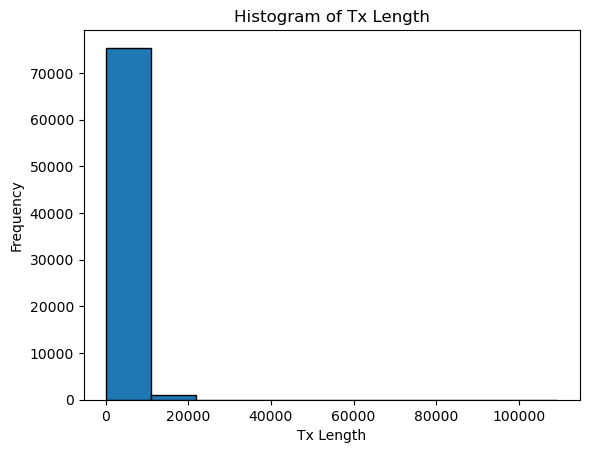

In [48]:
# Filter out null values
hist_fig=plot_hist(gene_df, 'Tx Length', 10, 'Histogram of Tx Length', 'Tx Length')
plt.show()

# Transcript length

This is hard to look at in a histogram, likely due to Titin throwing things off!

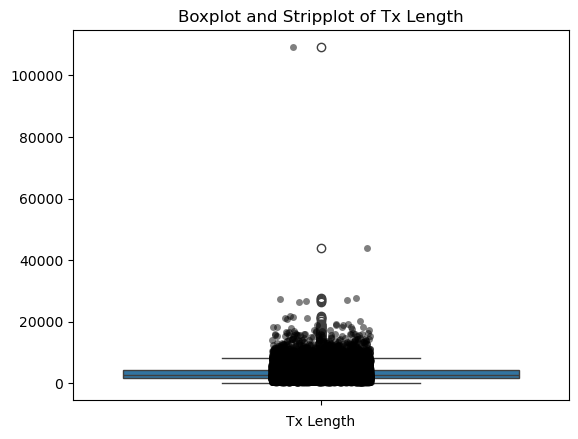

In [49]:
# Create a boxplot
sns.boxplot(data=gene_df, y='Tx Length')

# Create a stripplot
sns.stripplot(data=gene_df, y='Tx Length', color='black', alpha=0.5)

# Set plot title and labels
plt.title('Boxplot and Stripplot of Tx Length')
plt.xlabel('Tx Length')
plt.ylabel('')

# Show the plot
plt.show()

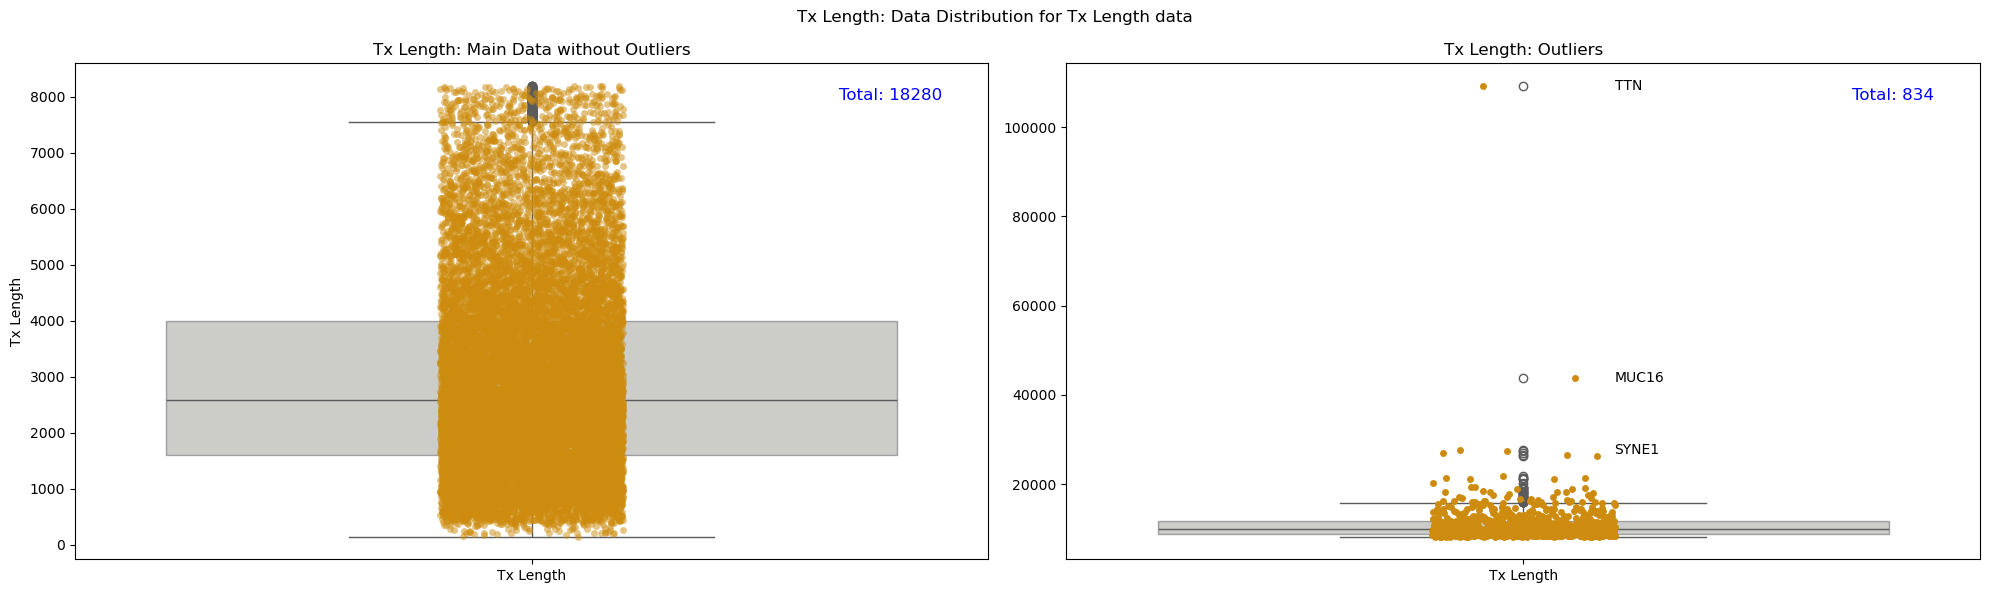

In [50]:
col='Tx Length'
fig = box_strip_plot(gene_df, 'Tx Length', 'Data Distribution for Tx Length data', 'Tx Length')
plt.tight_layout()
plt.show()

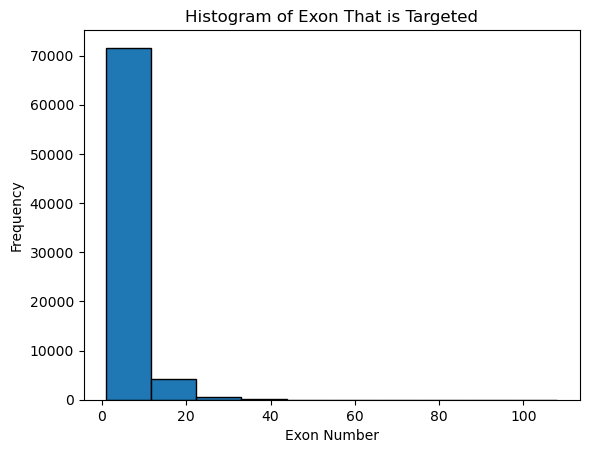

In [51]:
# Exon number
# Note: this is a per guide measuer as it is the exon that is targeted. 
hist_fig=plot_hist(guide_df, 'Exon Number', 10, 'Histogram of Exon That is Targeted', 'Exon Number')
# Display the plot
plt.show()

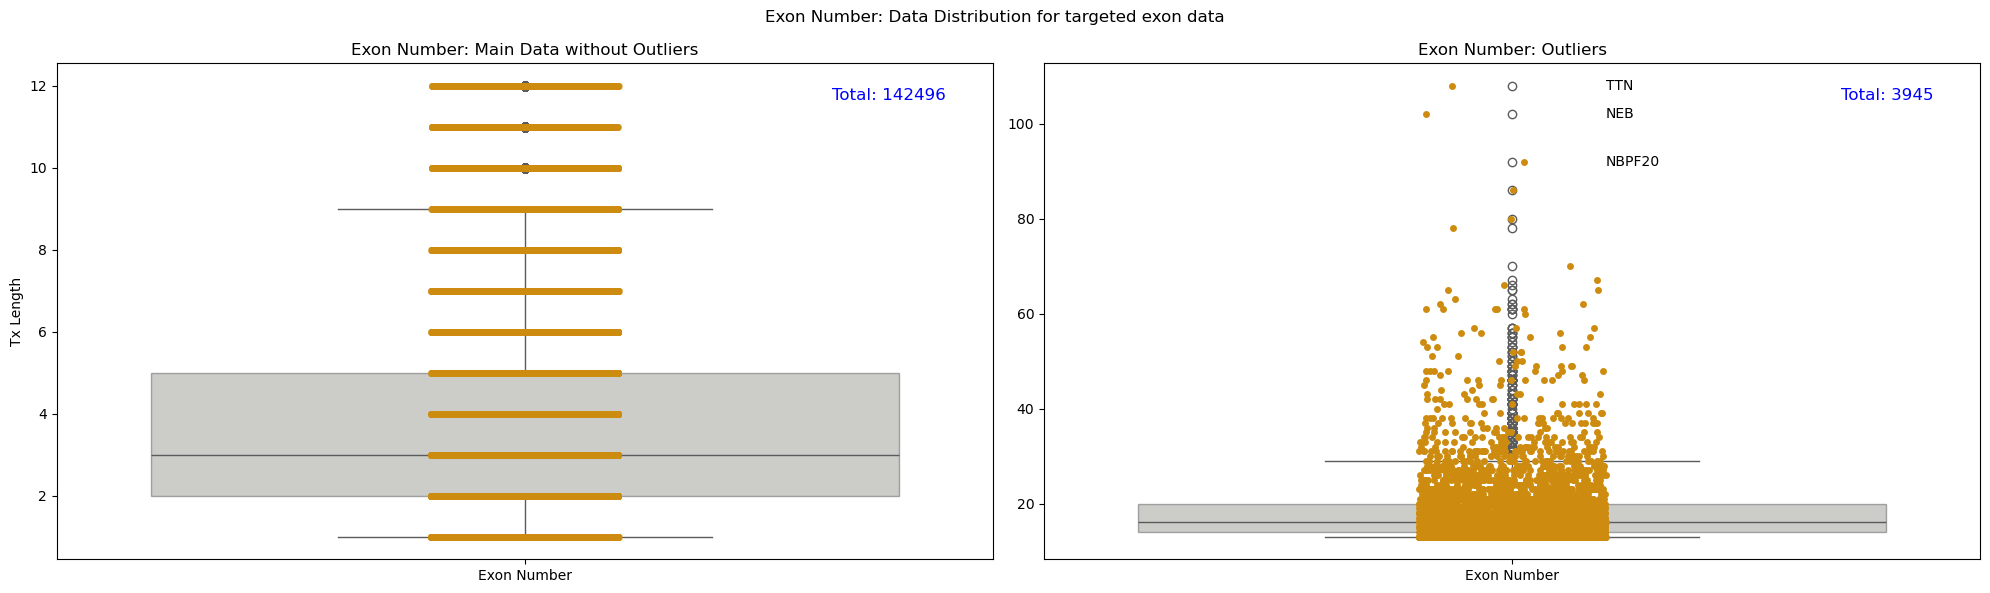

In [52]:
col='Exon Number'
fig = box_strip_plot(guide_df, 'Exon Number', 'Data Distribution for targeted exon data', 'Tx Length')
plt.tight_layout()
plt.show()

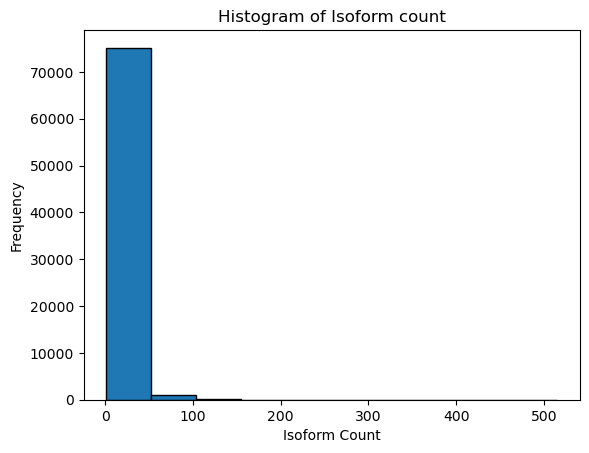

In [53]:
# Isoform number
hist_fig=plot_hist(gene_df, 'Gene Isoform Count', 10, 'Histogram of Isoform count', 'Isoform Count')
# Display the plot
plt.show()

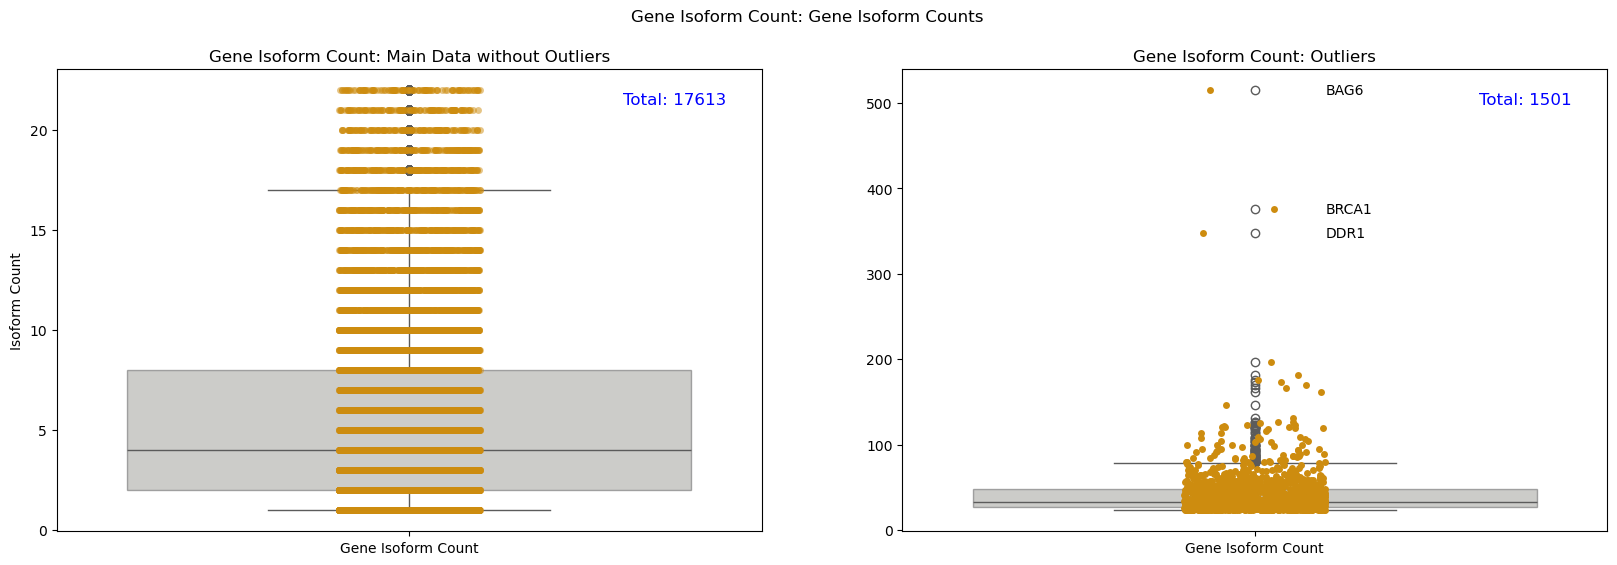

In [54]:
fig=box_strip_plot(gene_df, 'Gene Isoform Count', 'Gene Isoform Counts', 'Isoform Count')
plt.show()

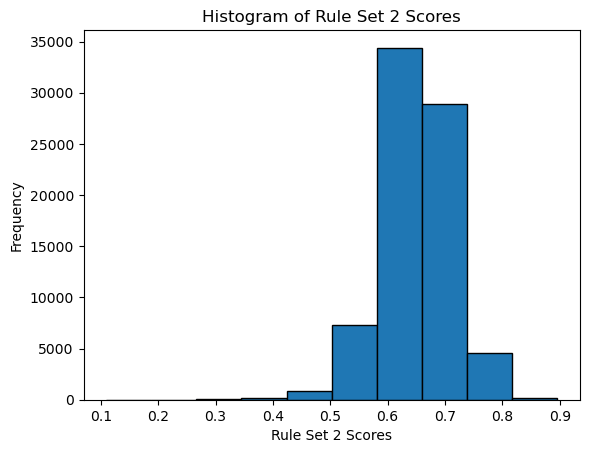

In [55]:
#Rule Set 2 score
#Note- this is a per guide measure- not a per gene measure

hist_fig=plot_hist(guide_df, 'Rule Set 2 score', 10, 'Histogram of Rule Set 2 Scores', 'Rule Set 2 Scores')
plt.show()

# Conclusion: Gene attributes

For many gene level attributes (e.g. isoform number and length) the bulk of the data is in one bin, but there are a large number of outliers in each category. While there is certainly class imbalance- there may enough data to look at the impact of these features on guide behaviour- particularly when comparing to the non-targeting guides. 

## Guide Counts

Now, let's look at the count data.

-[ ] Plot the raw count distributions per sample
-[ ] Normalize counts and plot distributions per sample. 

In [56]:
bru1_df=pd.read_excel(brunello, sheet_name=0, header=2)
show(bru1_df.head())

In [57]:
bru2_df=pd.read_excel(brunello, sheet_name=1, header=1)
show(bru2_df.head())

In [58]:
# Rename columns so you can put these all in one df
col1_dict={'pDNA': 'trac1_pDNA',
           'RepA': 'trac1_RepA',
           'RepB': 'trac1_RepB'}

col2_dict={'pDNA': 'trac2_pDNA',
           'RepA': 'trac2_RepA',
           'RepB': 'trac2_RepB',
           'RepC': 'trac2_RepC'}
bru1_df.rename(columns=col1_dict, inplace=True)
bru2_df.rename(columns=col2_dict, inplace=True)

show(bru1_df.head())
show(bru2_df.head())

In [59]:
brunello_df = bru1_df.merge(bru2_df, on='sgRNA Sequence')
show(brunello_df.head())

# System info

In [60]:
!conda list

# packages in environment at /Users/deannachurch/opt/anaconda3/envs/sb_capstone:
#
# Name                    Version                   Build  Channel
annotated-types           0.7.0              pyhd8ed1ab_0    conda-forge
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h02f2b3b_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
bcbio-gff                 0.7.1                    pypi_0    pypi
beautifulsoup4            4.12.3             pyha770c7